# Final Project: N-Body Simulator
Noah Holland-Moritz

In [1]:
#Import important modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2) Write Calculation Tools:
### |1| Functions from Homework E:

In [2]:
def forceGravMag(mass1, mass2, distance):
    '''
        Usage: forceGravMag(mass1,mass2,distance)
            Calculates the gravitaional force due to gravity between
                two objects.
        
        Inputs:
            mass1: The mass of the first object (kg)
            mass2: The mass of the second object (kg)
            distance: The separation distance between
                the two objects (m)
        
        Returns the magnitude of the force on each of the objects
            due to the other (one value)
    '''
    #Include 'softening' of force of gravity for close objects
    AU = 1.496e+11
    epsilon = 0.1*AU
    
    G = 6.67408e-11
    return G*mass1*mass2/(distance**2+epsilon**2)

def getMagnitude(vector):
    '''
        Usage: getMagnitude(vector)
            Calculates the magnitude of a vector of any size
        
        Inputs:
            vector: a numpy array (vector) of any length
        
        Returns the magnitude of the vector
    '''
    sum = 0
    for element in vector:
        sum = sum +element**2
    
    return np.sqrt(sum)

def getUnitVector(pos1, pos2):
    '''
        Usage: getUnitVector(pos1,pos2)
            Returns the unit vector in the direction between two positions
        
        Inputs:
            pos1: The first position's coordinates (any number of dimensions)
            pos2: The second position's coordinates (any number of dimensions,
                    but if the dimensions do not match pos1, then the missing
                    dimensions are defaulted to zero)
            
        Returns a vector with the same number of dimensions as the inputs
            in the direction between the two points (with magnitude 1)
    '''
    dims = np.max([len(pos1),len(pos2)])
    pos1.resize(dims,refcheck=False)
    pos2.resize(dims,refcheck=False)
    
    return (pos2-pos1)/getMagnitude(pos2-pos1)

def forceVector(mass1,mass2,pos1,pos2):
    '''
        Usage: forceVector(mass1,mass2,pos1,pos2)
            Calculates the vector of the force of the second object on the first.
            This is equal to the negative force vector of the first object on the second.
            
        Inputs:
            mass1: Mass of the first object (kg).
            mass2: Mass of the second object (kg).
            pos1: Coordinate position of the first object 
                (any number of dimensions) (meters)
            pos2: Coordinate position of the second object 
                (any number of dimensions) (meters)
            
        Returns the vector quantity of the force exerted by the second object 
            on the first one.
    '''
    unitVec = getUnitVector(pos1,pos2)
    return unitVec*forceGravMag(mass1,mass2,getMagnitude(pos2-pos1))

def netForceVec(m,p):
    '''Calculates the net force on each particle due to every other.
        
        Inputs:
            m: A list of masses for each particle (numpy array)
            p: a list of positions for each particle. (numpy array)
                Each position is a vector (list) of three numbers; x,y,z
        
        Returns:
            vectors: a list of vectors of the force on each particle.
                Order is the same as order of the inputs.  starting position
                of each vector is not included, only the vector itself.
        '''
    totalVec = np.zeros((len(m),3))
    for i in range(len(m)):
        #Calculate the force for each particle
        for j in range(len(m)):
            #The force is the sum of the forces from each OTHER particle
            #Thus, we check to see if the particle we're calculating is the same as in the above loop
            if i != j:
                force = forceVector(m[i],m[j],p[i],p[j])
                totalVec[i] = totalVec[i]+force
    
    return totalVec

In [3]:
#Test calculate netForceVec using two particles.  
#The forces should be equal and opposite in direction

masses = [20,60]
pos = np.array([np.array([0,0,0]),np.array([10,5,0])])
print netForceVec(masses,pos)

[[  3.20076995e-28   1.60038497e-28   0.00000000e+00]
 [ -3.20076995e-28  -1.60038497e-28   0.00000000e+00]]


### |2| Copy and test updateParticles

In [4]:
def updateParticles(masses, positions, velocities, dt):
    """
    Evolve particles in time via leap-frog integrator scheme. This function
    takes masses, positions, velocities, and a time step dt as

    Parameters
    ----------
    masses : np.ndarray
        1-D array containing masses for all particles, in kg
        It has length N, where N is the number of particles.
    positions : np.ndarray
        2-D array containing (x, y, z) positions for all particles.
        Shape is (N, 3) where N is the number of particles.
    velocities : np.ndarray
        2-D array containing (x, y, z) velocities for all particles.
        Shape is (N, 3) where N is the number of particles.
    dt : float
        Evolve system for time dt (in seconds).

    Returns
    -------
    Updated particle positions and particle velocities, each being a 2-D
    array with shape (N, 3), where N is the number of particles.

    """

    startingPositions = np.array(positions)
    startingVelocities = np.array(velocities)

    # how many particles are there?
    nParticles, nDimensions = startingPositions.shape

    # make sure the three input arrays have consistent shapes
    assert(startingVelocities.shape == startingPositions.shape)
    assert(len(masses) == nParticles)

    # calculate net force vectors on all particles, at the starting position
    startingForces = np.array(netForceVec(masses, startingPositions))

    # calculate the acceleration due to gravity, at the starting position
    startingAccelerations = startingForces/np.array(masses).reshape(nParticles, 1)

    # calculate the ending position
    nudge = startingVelocities*dt + 0.5*startingAccelerations*dt**2
    endingPositions = startingPositions + nudge

    # calculate net force vectors on all particles, at the ending position
    endingForces = np.array(netForceVec(masses, endingPositions))

    # calculate the acceleration due to gravity, at the ending position
    endingAccelerations = endingForces/np.array(masses).reshape(nParticles, 1)

    # calculate the ending velocity
    endingVelocities = (startingVelocities +
                        0.5*(endingAccelerations + startingAccelerations)*dt)

    return endingPositions, endingVelocities

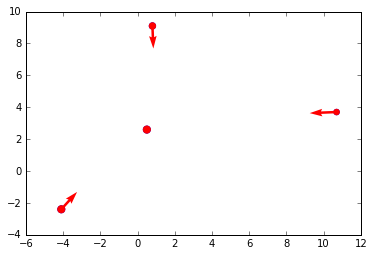

In [5]:
masses = np.array([50.0,40.0,50.0,30.0])

pos = np.array([np.array([ 0.5,   2.6,  0.05]),
             np.array([ 0.8,   9.1,  0.10]),
             np.array([-4.1,  -2.4,  0.80]),
             np.array([10.7,   3.7,  0.00])])

#Testing the above function using a small dataset
time = 2.5*24*60*60 #2.5 days

[positions,velocities] = updateParticles(masses, pos, np.zeros((len(masses),3)), time)
plotable = np.transpose(pos[:,0:2])
plotable2 = np.transpose(positions[:,0:2])

#Plotting initial positions as blue, final positions as red, velocities as red arrows
plt.scatter(plotable[0],plotable[1],color = 'b',s=masses)
plt.scatter(plotable2[0],plotable2[1],color='r',s=masses)
plt.quiver(plotable2[0],plotable2[1],np.transpose(velocities[:,0:2])[0],np.transpose(velocities[:,0:2])[1],color='r')


In the above image, blue points are initial positions, red points and arrows are final positions and velocities

### |3| calculateTrajectories

In [6]:
def calculateTrajectories(masses, positions, velocities, totalTime, timestep):
    '''
    Continuously evolve particles in time via leap-frog integrator scheme.

    Parameters
    ----------
    masses : np.ndarray
        1-D array containing masses for all particles, in kg
        It has length N, where N is the number of particles.
    positions : np.ndarray
        2-D array containing (x, y, z) positions for all particles.
        Shape is (N, 3) where N is the number of particles.
    velocities : np.ndarray
        2-D array containing (x, y, z) velocities for all particles.
        Shape is (N, 3) where N is the number of particles.
    totalTime : float
        Evolve system for a total amount of time totalTime (in seconds).
    timestep : float
        Each leapfrog step has a change in time timestep (in seconds).

    Returns
    -------
    times : np.ndarray
        1-D array containing each time at which particle positions and velocities
        were calculated.  It has length nTimes (totalTime/timestep, rounded down)
    positions : np.ndarray
        3-D array containing the positions of each particle at each corresponding
        time in the times array.  (nParticles x nDimensions x nTimes)
    velocities : np.ndarray
        3-D array containing the velocities of each particle at each corresponding
        time in the times array. (nParticles x nDimensions x nTimes)
    '''
    # 
    nParticles, nDimensions = positions.shape
    
    # Create times array.  Time zero is designated as the start
    # DOES NOT INCLUDE totalTime!
    times = np.arange(0,totalTime,timestep)
    
    #Initialize 3D arrays:
    pos = np.zeros((nParticles,nDimensions,len(times)))
    vel = np.zeros((nParticles,nDimensions,len(times)))
    pos[:,:,0] = positions
    vel[:,:,0] = velocities
    
    for i in range(len(times)-1):
        [currpos,currvel] = updateParticles(masses,pos[:,:,i],vel[:,:,i],timestep)
        pos[:,:,i+1] = currpos
        vel[:,:,i+1] = currvel
    
    return times, pos, vel

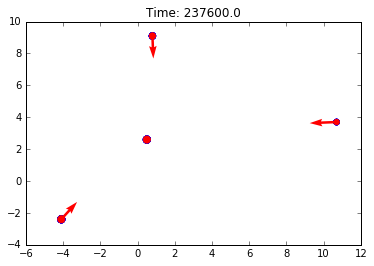

In [7]:
[times,positions,velocities] = calculateTrajectories(masses, pos, np.zeros((len(masses),3)), 1.2*time+1, time/10)

# let's plot each time step below; Shouldn't be too many.
for i in range(len(times)-1):
    currpos = np.transpose(positions[:,0:2,i])
    currvel = np.transpose(velocities[:,0:2,i])

    plt.scatter(currpos[0],currpos[1],color = 'b',s=masses)
    
    plt.title("Time: {}".format(times[i]))

    
currpos = np.transpose(positions[:,0:2,len(times)-1])
currvel = np.transpose(velocities[:,0:2,len(times)-1])

plt.scatter(currpos[0],currpos[1],color = 'r',s=masses)
plt.quiver(currpos[0],currpos[1],currvel[0],currvel[1],color='r')

In the above graph, each particle's positions is changed at each time step.  The red particles with arrows are the final positions and velocities for each one.  

## 3) Earth in (circular) orbit around the Sun:
### |4| Testing the code with initial conditions

In [8]:
au = 1.496e11
masses = np.array([1.989e30,5.972e24])
pos = au*np.array([np.array([-3e-6,0,0]),np.array([0.999997,0,0])])
vel = np.array([np.array([0,-8.94e-2,0]),np.array([0,2.98e4,0])])

In [9]:
totalTime = 1000*24*60*60+1 #1000 days
timestep = 0.1*24*60*60 #0.1 day

[times,positions,velocities] = calculateTrajectories(masses, pos, vel, totalTime, timestep)
# Convert positions to AU and times to days
positions = positions/au
times = times/60/60/24

### |5| Plotting the data

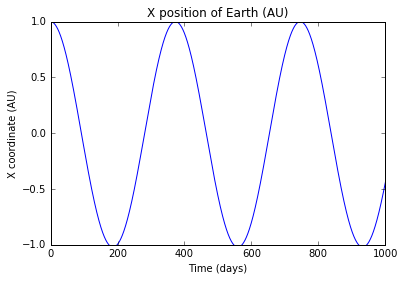

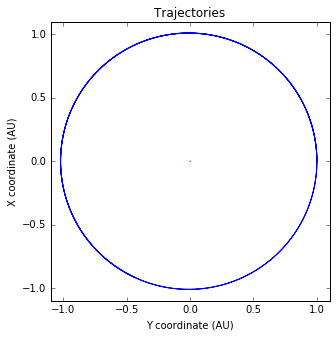

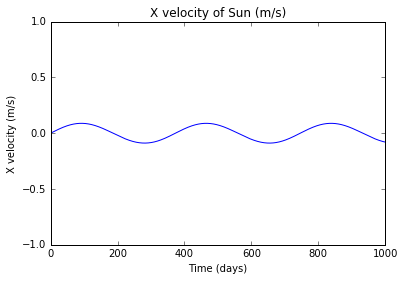

In [10]:
plt.plot(times,positions[1,0,:]);
plt.title("X position of Earth (AU)");
plt.xlabel("Time (days)");
plt.ylabel('X coordinate (AU)');
plt.xlim([0,1000]);
plt.ylim([-1,1]);
plt.show();

plt.figure(figsize=(5,5))
plt.plot(positions[1,0,:],positions[1,1,:]);
plt.plot(positions[0,0,:],positions[0,1,:],color='r');
plt.title("Trajectories");
plt.xlabel("Y coordinate (AU)");
plt.ylabel('X coordinate (AU)');
plt.axis('scaled')
plt.xlim([-1.1,1.1]);
plt.ylim([-1.1,1.1]);
plt.show();

plt.plot(times,velocities[0,0,:]);
plt.title("X velocity of Sun (m/s)");
plt.xlabel("Time (days)");
plt.ylabel('X velocity (m/s)');
plt.xlim([0,1000]);
plt.ylim([-1,1]);
plt.show();

The period of the earth's rotation is roughly 365 days, according to the first plot.  This makes perfect sense since our years are 365 days long.  

In order to detect an earth-like planet around a sun-like star, we need to be able to measure the radial velocity of the star within 0.1 m/s at least.  The sun's x velocity in the third plot above almost never goes above 0.1 m/s, so that's the kind of accuracy you need.  

### |6| Changing initial velocities

In [11]:
#Cut velocities in half
vel = vel/2

#Redo calculations
[times,positions,velocities] = calculateTrajectories(masses, pos, vel, totalTime, timestep)
# Convert positions to AU and times to days
positions = positions/au
times = times/60/60/24

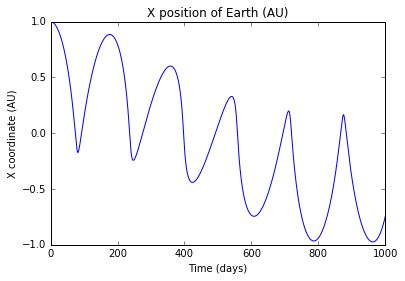

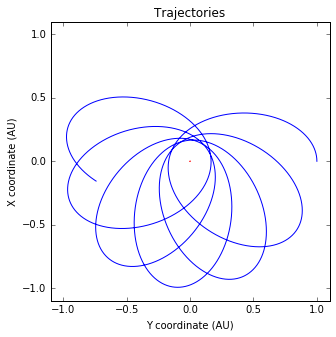

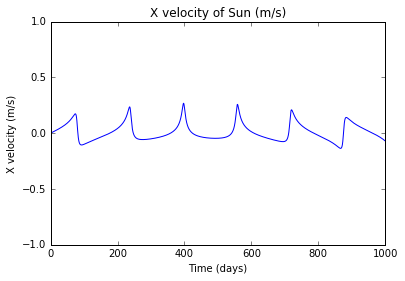

In [12]:
plt.plot(times,positions[1,0,:]);
plt.title("X position of Earth (AU)");
plt.xlabel("Time (days)");
plt.ylabel('X coordinate (AU)');
plt.xlim([0,1000]);
plt.ylim([-1,1]);
plt.show();

plt.figure(figsize=(5,5))
plt.plot(positions[1,0,:],positions[1,1,:]);
plt.plot(positions[0,0,:],positions[0,1,:],color='r');
plt.title("Trajectories");
plt.xlabel("Y coordinate (AU)");
plt.ylabel('X coordinate (AU)');
plt.axis('scaled')
plt.xlim([-1.1,1.1]);
plt.ylim([-1.1,1.1]);
plt.show();

plt.plot(times,velocities[0,0,:]);
plt.title("X velocity of Sun (m/s)");
plt.xlabel("Time (days)");
plt.ylabel('X velocity (m/s)');
plt.xlim([0,1000]);
plt.ylim([-1,1]);
plt.show();

With the new starting velocities, the orbit of the planet becomes much more elliptical.  This makes sense, as it does not have the speed necessary to maintain a circular orbit.  

What's particularly interesting is how the the sun's orbit becomes much more jagged.  This is because when the earth is close, it moves very quickly and pulls much more strongly on the sun.  Thus, the jagged point.  When the earth is farther away, it has less effect and the sun's orbit is relatively smooth.  

## 4) The circumbinary exoplanet Kepler-16ABb:
### |7| Loading the initial conditions:

In [13]:
fileData = np.loadtxt('/home/zabe0091/nbody/initialconditions/kepler16.txt')

In [14]:
masses = fileData[:,0]
positions = fileData[:,1:4]
velocities = fileData[:,4:7]

### |8| Plotting initial positions

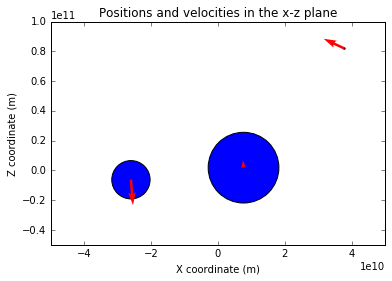

In [15]:
plt.scatter(positions[:,0],positions[:,2],s=5000*(masses/masses.max()));
plt.quiver(positions[:,0],positions[:,2],velocities[:,0],velocities[:,2],color='r')
plt.title('Positions and velocities in the x-z plane');
plt.xlabel('X coordinate (m)');
plt.ylabel('Z coordinate (m)');
plt.xlim((-5e10,5e10));
plt.ylim((-0.5e11,1e11));

### |9| Calculate trajectories for 500 days

In [16]:
totalTime = 500*24*60*60 #500 days in seconds
timestep = 0.5*24*60*60 #0.5 days in seconds

[times,positions,velocities] = calculateTrajectories(masses,positions,velocities,totalTime,timestep)

### |10| Create animation of particles over time

In [17]:
replot = False
# Set this to false to skip 
# redrawing and saving of the animation.
# Saves lots of time if you've already run 
# the code once. This cell will redraw and save 
# the animation if the file does not exist anyway

######### BEGIN ANIMATION CODE ############

# First we need to setup imbedded animation tools:
# Check out this link to see where I got the supporting code:
# http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
import os.path

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""
def anim_to_html(anim,name):
    if not hasattr(anim, '_encoded_video'):
        if ((not(os.path.isfile(name))) or replot):
            anim.save(name, writer = 'avconv', fps=60, extra_args=['-vcodec', 'libx264'])
        video = open(name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

In [18]:
from IPython.display import HTML

def display_animation(anim,name):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim,name))

In [19]:
import matplotlib.animation as ani

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-1.5e11,1.5e11), ylim=(-1.5e11,1.5e11))
plt.suptitle('Orbit of Kepler 16ABb',fontsize=10)
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')

# Initialization of the animation.  Scat1 is the scatter of planets. 
# Scat2 is just a circle around the smallest, to hilight it
def init():
    ax.set_title('',animated=True)
    ax.scat1 = ax.scatter([],[],s=250*(masses/masses.max()))
    ax.scat2 = ax.scatter([],[], s=120, facecolors='none', edgecolors='r')
    return ax.scat1,ax.scat2

# animation function.  This is called sequentially
def animate(i):
    ax.set_title('Day {} of {}'.format(i+1,len(times)),fontsize=8)
    ax.scat1.set_offsets(np.transpose([positions[:,0,i],positions[:,2,i]]))
    ax.scat2.set_offsets(np.transpose([positions[2,0,i],positions[2,2,i]]))
    return ax.scat1,ax.scat2

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = ani.FuncAnimation(fig, animate, init_func=init, frames=len(times), interval=10, blit=True)

# call our new function to display and save the animation
display_animation(anim,"Kepler 16ABb.mp4") 
# Animation is also saved as "Kepler 16ABb.mp4"

## 5) Choose Your Own Adventure:
### |11| Loading the initial conditions:

In [49]:
def tinyCluster(N=20, maximum_mass=0.1):
    '''This function creates N-body initial conditions for 
    a (very) cartoon model of stellar cluster.
    
    WARNING: With these initial conditions, it's very easy 
    for some of your particles to have very close approaches.
    This means, to properly resolve their motion, you either
    need to:
    
        (a) take very short time steps so you accurately
        capture the accelerations of these close approaches
        
        (b) modify your force of gravity calculation by 
        including a "softening length". That is, in the 
        place where you calculate F = GMm/r**2, you instead
        calculate the magnitude of the force as GMm/s**(2,
        where s = np.sqrt(r**2 + epsilon**2) where epsilon
        is some small number like 0.1 AU. This "softens" the
        strong forces that would otherwise result from very 
        close approaches.
    
    Inputs:
        N (= 30 by default)
            the total number of particles to create
        maximum_mass (= 0.01 solar masses by default)
            the maximum mass of the particles that can go
            into the cluster; the masses of the particles 
            will be random, drawn from a uniform distribution
            with this as the maximum

    Outputs:
        this function returns three arrays
            masses [shape is (nParticles)]
            positions [shape (nParticles, nDimensions)]
            velocities [shape (nParticles, nDimensions)]
            
    Example Usage:
        mParticles, initialPositions, initialVelocities = tinyCluster()
    '''
    G = 6.67408e-11
    au = 1.496e+11
    
    maximum_mass = maximum_mass*1.989e30
    
    # set up the masses
    masses = np.random.uniform(0, 1, N)*maximum_mass

    # convert to cartesian coordinates
    positions = np.random.normal(0, 1.0, [N,3])*au*5
    radii = np.sqrt(np.sum(positions**2, 1))
    mass_enclosed = np.array([np.sum(masses[radii <= r]) for r in radii]) 
    sigma = np.sqrt(G*mass_enclosed/radii)
    
    #directions = np.array([np.cross(np.random.uniform(size=3), positions[i]) for i in range(N)])
    #for i in range(N):
    #    directions[i,:] /= np.sqrt(np.sum(directions[i,:]**2))
        
    # calculate velocities for circular orbits
    #velocities = (sigma*np.random.normal(0,1,N))[:,np.newaxis]*directions   
    velocities = sigma[:,np.newaxis]*np.random.normal(0,1,[N,3])*0.5

    # return them as three separate arrays
    return masses, positions, velocities

masses,positions,velocities = tinyCluster(N=30)

In [50]:
totalTime = 10000*24*60*60 #500 days in seconds
timestep = 10*24*60*60 #0.5 days in seconds

[times,positions,velocities] = calculateTrajectories(masses,positions,velocities,totalTime,timestep)

In [51]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-10e11,10e11), ylim=(-10e11,10e11))
plt.suptitle('Orbit of Kepler 16ABb',fontsize=10)
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordinate (m)')

# Initialization of the animation.  Scat1 is the scatter of planets. 
# Scat2 is just a circle around the smallest, to hilight it
def init():
    ax.set_title('',animated=True)
    ax.scat1 = ax.scatter([],[],s=500*(masses/masses.max()))
    return ax.scat1,

# animation function.  This is called sequentially
def animate(i):
    ax.set_title('Day {} of {}'.format(i+1,len(times)),fontsize=8)
    ax.scat1.set_offsets(np.transpose([positions[:,0,i],positions[:,1,i]]))
    return ax.scat1,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = ani.FuncAnimation(fig, animate, init_func=init, frames=len(times), interval=10, blit=True)

# call our new function to display and save the animation
display_animation(anim,"cluster.mp4") 
# Animation is also saved as "Kepler 16ABb.mp4"